In [1]:
!nvidia-smi

Sun Aug 28 09:45:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:1A:00.0 Off |                  Off |
| 33%   25C    P8    31W / 260W |      3MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     On   | 00000000:1C:00.0 Off |                  Off |
| 50%   

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings("ignore")

from Parse_TFrecords import *
from define_model import *
from load_label import *
from utilities import *
import gc
import tensorflow as tf
import json
import matplotlib.image as mpimg
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
from sklearn.metrics import classification_report, average_precision_score

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
print(tf.__version__)

2.8.0


## Model Fusion - Weighted Bagging

In [11]:
archis = ['DenseNet121', 'ResNet50V2', 'Xception', 'MobileNetV2']

data = 'emory'
split = 'val'


df = pd.DataFrame()

for i in archis:
    outfile = 'preds/{d}/{j}_preds/{i}_preds.npy'.format(d=data,j=split, i=i)

    df[i] = np.reshape(np.load(outfile), (-1)).tolist()

In [12]:
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import dendrogram, linkage
from functools import partial
from scipy.spatial.distance import pdist

cosine_func = partial(pdist, metric='cosine')
np.random.seed(1)

X = np.random.rand(15, 12) # 15 samples, with 12 dimensions each
fig = ff.create_dendrogram(df.T, labels=archis, distfun=cosine_func, linkagefun=lambda x: linkage(x, 'average'))
fig.update_layout(width=800, height=500)
fig['layout'].update({'width':800, 'height':600, 'title': 'Dendrogram', 'title_x': 0.5, 'title_y':0.88, 
                    'xaxis': {'title': 'Base Models'}, 'yaxis': {'title': 'Cosine Distance'}})
fig.show()

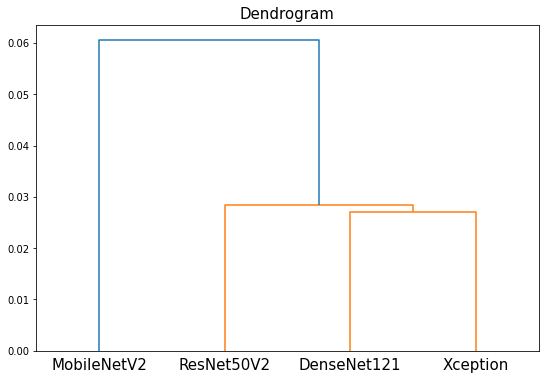

In [13]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(9, 6))  
plt.title("Dendrogram", fontdict={'fontsize': 15})

dend = shc.dendrogram(shc.linkage(df.T, method='average', metric='cosine'), labels=archis, get_leaves=True, leaf_font_size=15)

j = json.dumps(dend)

f = open("bagging_dend_emory/average_dend.json","w")

# write json object to file
f.write(j)

# close file
f.close()

In [17]:
archis = ['DenseNet121', 'ResNet50V2', 'Xception', 'MobileNetV2']

data = 'emory'
split = 'test'


df = pd.DataFrame()

for i in archis:
    outfile = 'preds/{d}/{j}_preds/{i}_preds.npy'.format(d=data,j=split, i=i)

    df[i] = np.reshape(np.load(outfile), (-1)).tolist()

y_label, y_demo = get_data_label(data, split, True)

In [15]:
with open("bagging_dend_emory/average_dend.json", "r") as read_content:
    dend = json.load(read_content)
    
temp = pd.DataFrame()
for i in range(len(archis)-1):
    a = dend['icoord'][i][1]
    b = dend['icoord'][i][2]
    if (a-5)%10 == 0:
        print('a', dend['ivl'][int((a-5)/10)])
        val_a = df[dend['ivl'][int((a-5)/10)]]
    else:
        print('a', str(a))
        val_a = temp[str(a)]
        
    if (b-5)%10 == 0:
        print('b', dend['ivl'][int((b-5)/10)])
        val_b = df[dend['ivl'][int((b-5)/10)]]
    else:
        print('b', str(b))
        val_b = temp[str(b)]
    
    temp[str((a+b)/2)] = (val_a + val_b)/2
    
    print('-------------------')

a DenseNet121
b Xception
-------------------
a ResNet50V2
b 30.0
-------------------
a MobileNetV2
b 22.5
-------------------


In [16]:
thresh = get_thresh(y_label, temp[str((a+b)/2)], 'Youden')

test_CI(temp[str((a+b)/2)].values, y_label, thresh)

gc.collect()

AUC       : 0.75, CI: [0.74 - 0.76]
Precision : 0.31, CI: [0.30 - 0.31]
Recall    : 0.76, CI: [0.75 - 0.78]
F1-Score  : 0.44, CI: [0.43 - 0.45]
AUPRC     : 0.41, CI: [0.40 - 0.42]
Balanced ACC : 0.68, CI: [0.67 - 0.69]


5212

## Model Fusion - Unweighted Bagging

In [21]:
archis = ['DenseNet121', 'ResNet50V2', 'Xception', 'MobileNetV2']

data = 'emory'
split = 'test'


df = pd.DataFrame()

for i in archis:
    outfile = 'preds/{d}/{j}_preds/{i}_preds.npy'.format(d=data,j=split, i=i)

    df[i] = np.reshape(np.load(outfile), (-1)).tolist()

y_label, y_demo = get_data_label(data, split, True)

df = df.mean(axis=1)

In [23]:
thresh = get_thresh(y_label, df, 'Youden')

test_CI(df.values, y_label, thresh)

gc.collect()

AUC       : 0.75, CI: [0.75 - 0.76]
Precision : 0.30, CI: [0.30 - 0.31]
Recall    : 0.78, CI: [0.77 - 0.79]
F1-Score  : 0.44, CI: [0.43 - 0.45]
AUPRC     : 0.42, CI: [0.40 - 0.43]
Balanced ACC : 0.68, CI: [0.67 - 0.69]


398

## Model Fusion - MIMIC/Emory Model Bagging

In [33]:
archis = ['DenseNet121', 'DenseNet201', 'ResNet50V2', 'ResNet152V2', 'Xception', 'InceptionV3', 'InceptionResNetV2', 'MobileNetV2']
split = 'test'

df1 = pd.DataFrame()

for i in archis:
    outfile = 'preds/mimic/test_preds/merged_{i}_preds.npy'.format(i=i)

    df1[i] = np.reshape(np.load(outfile), (-1)).tolist()
    
df2 = pd.DataFrame()

for i in archis:
    outfile = 'preds/emory/test_preds/merged_{i}_preds.npy'.format(i=i)

    df2[i] = np.reshape(np.load(outfile), (-1)).tolist()
    
df = pd.concat([df1, df2])
df = df.mean(axis=1)

y_label_mimic, y_demo_mimic = get_data_label('mimic', split, True)
y_label_emory, y_demo_emory = get_data_label('emory', split, True)

y_label = np.concatenate([y_label_mimic, y_label_emory], axis=0)
y_demo = np.concatenate([y_demo_mimic, y_demo_emory], axis=0)

In [34]:
thresh = get_thresh(y_label, df, 'Youden')

test_CI(df.values, y_label, thresh)

gc.collect()

AUC       : 0.76, CI: [0.76 - 0.77]
Precision : 0.39, CI: [0.38 - 0.40]
Recall    : 0.68, CI: [0.67 - 0.69]
F1-Score  : 0.50, CI: [0.49 - 0.50]
AUPRC     : 0.50, CI: [0.49 - 0.50]
Balanced ACC : 0.69, CI: [0.69 - 0.69]


651

## Fairness Analysis

In [ ]:
race_list = ['White', 'Black', 'Latino', 'Others', 'Asian']

for race_num, race in enumerate(race_list):
    print(race)
    
    idx = []
    for i, l in enumerate(y_demo):
        if (l['Race']==race_num):
            idx.append(i)
            
    temp_df = df.iloc[idx].values
    temp_label = y_label[idx]
    
    thresh = get_thresh(temp_label, temp_df, 'Youden')

    test_CI(temp_df, temp_label, thresh)

    gc.collect()

In [ ]:
gender_list = ['Female', 'Male']

for gender_num, gender in enumerate(gender_list):
    print(gender)
    
    idx = []
    for i, l in enumerate(y_demo):
        if (l['Gender']==gender_num):
            idx.append(i)

    temp_df = df.iloc[idx].values
    temp_label = y_label[idx]
    
    thresh = get_thresh(temp_label, temp_df, 'Youden')

    test_CI(temp_df, temp_label, thresh)

    gc.collect()

In [ ]:
age_list = ['0-40', '40-60', '60-80', '80-']

for age_num, age in enumerate(age_list):
    print(age)
    
    idx = []
    for i, l in enumerate(y_demo):
        if (l['Age']==age_num):
            idx.append(i)

    temp_df = df.iloc[idx].values
    temp_label = y_label[idx]
    
    thresh = get_thresh(temp_label, temp_df, 'Youden')

    test_CI(temp_df, temp_label, thresh)

    gc.collect()